# Satellite data access through Google Earth Engine

Mahdi Khodadadzadeh
October 2022


In this notebook, you will practice some functionalities of the the Google Earth Engine Python API. This exercise is prepared with some materials from this [tutorial](https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api). 

## What is GEE?

[GEE](https://earthengine.google.com/) combines a multi-petabyte catalog of satellite imagery and geospatial datasets with planetary-scale analysis capabilities. Scientists, researchers, and developers use Earth Engine to detect changes, map trends, and quantify differences on the Earth's surface. Earth Engine is now available for commercial use, and remains **free for academic and research use**. Particularly, GEE provides petabyte-scale catalog of public and free-to-use geospatial datasets. Visit the [Earth Engine Data Catalog](https://developers.google.com/earth-engine/datasets/catalog) and explore datasets using the search bar or browsing by tag.

To use GEE you need to connect to the Earth Engine service through one of the APIs. In this tutorial we will use the Python API. See [here](https://developers.google.com/earth-engine) to know more about all the available APIs.

To connect to the GEE APIs, you need to have an active GEE account. You can sign up for GEE if you don’t have an active account yet. Go [here](https://code.earthengine.google.com/) and create or link your current Google account to a new account of GEE. Then, GEE will request access to your Google account, that you need to allow it. After that, you need to fill out an application form and submit it. Once you successfully submit the form, you will receive a "Thank You" message. Then you need to keep an eye on your gmail inbox to receive a "Welcome to Google Earth Engine!" email, which confirms that you are able to login using your Google account on "code.earthengine.google.com" and to use any GEE API. It will take a few minutes, more rarely some days.


## Authentication 

After importing `ee`, the `ee.Authenticate()` line should be run once to grant the notebook access to Earth Engine using your account. This triggers the authentication flow, which is easy to complete. [Here](https://developers.google.com/earth-engine/guides/python_install#authentication), you can find a step-by-step instructions.


In [1]:
import ee

# # If you are running this notebook for the first time, you need to activate the command below for the authentication flow:
# ee.Authenticate()


## Initializing 

Run the following scripts to initialize the API. You should see this message "Google Earth Engine has initialized successfully!"

In [2]:
try:
    # Initialize the library.
    ee.Initialize()
    print('Google Earth Engine has initialized successfully!')
except ee.EEException as e:
    print('Google Earth Engine has failed to initialize!')
except:
    print("Unexpected error:", sys.exc_info()[0])
    raise

Google Earth Engine has initialized successfully!


## Getting Data and Visualizing

In the GEE, datasets can be of different types:

- `ee.Feature`: a geometric object with a list of properties (vector data)
- `ee.Image`: an image that may include several bands (raster data)
- `ee.FeatureCollection`: groups of features
- `ee.ImageCollection`: groups of images


Let's use the [geemap](https://geemap.org/) Python package for defining the study area and the visualization. geemap is a Python package for interactive mapping with GEE. For video tutorials and notebook examples for the geemap Python package, please visit the [examples page](https://github.com/giswqs/geemap/tree/master/examples). For complete documentation on geemap modules and methods, please visit the [API Reference](https://geemap.org/geemap/#geemap-tutorials).

In [3]:
import geemap

Now let's call the interactive map from geemap to select a region or a point of interest. Please note that the following line opens a default basemap which is a Google Map (additional basemaps can be added using the `Map.add_basemap()` function).

In [8]:
Map1 = geemap.Map()
Map1

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Now let's zoom in (using a mouse) to the region of Enschede. Using the bar at the left side of the map, select a rectangle on this map (i.e., covering Enschede  and surroundings). This region will appear as "Drawn Features" layer on this map. You can check it out using the tool icon on the top right corner of the map. Then, you can retrieve this region geometry using the following lines.

In [9]:
fc = ee.FeatureCollection(Map1.draw_last_feature)
region = fc.geometry()
cords = region.getInfo()['coordinates']
cords

[[[6.845196, 52.246817],
  [6.812922, 52.236936],
  [6.841419, 52.206019],
  [6.844852, 52.188763],
  [6.868886, 52.177185],
  [6.902532, 52.183501],
  [6.926909, 52.194866],
  [6.921416, 52.206019],
  [6.922446, 52.211489],
  [6.931716, 52.213382],
  [6.936866, 52.229367],
  [6.925536, 52.238408],
  [6.923132, 52.254594],
  [6.912146, 52.258167],
  [6.868199, 52.254594],
  [6.845196, 52.246817]]]

In [3]:
# or alternatively use the following predefined rectangle
region = ee.Geometry.Polygon(
[[[6.845196, 52.246817],
  [6.812922, 52.236936],
  [6.841419, 52.206019],
  [6.844852, 52.188763],
  [6.868886, 52.177185],
  [6.902532, 52.183501],
  [6.926909, 52.194866],
  [6.921416, 52.206019],
  [6.922446, 52.211489],
  [6.931716, 52.213382],
  [6.936866, 52.229367],
  [6.925536, 52.238408],
  [6.923132, 52.254594],
  [6.912146, 52.258167],
  [6.868199, 52.254594],
  [6.845196, 52.246817]]]
)

Now it's the time to gather the Sentinel 2 images of this region. To know how to gather an specific data you can always check the [GEE data catalogue](https://developers.google.com/earth-engine/datasets). For example, according to the [Sentinel 2 satellite images catalogue ](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED), we can access these images using the "ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")" snippet.

Now let's find a recent [Sentinel 2 Multispectral satellite image](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) that covers the selected region during the last summer. Let's consider all the images with less than 10% cloud coverage. We don't want very cloudy images!

In [4]:
myCollection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(region) \
    .filterDate('2022-06-01', '2022-08-30') \
    .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)

In [5]:
listOfImages = myCollection.aggregate_array('system:index').getInfo()
print('Number of images in the collection: ', len(listOfImages))

Number of images in the collection:  10


The first image and clip to the region and visualize it on the map.

Often, we don't need a whole image for furthur analysis. We can simply crop an image and select a smaller part of an image for the region of interest. You can use [Clip](https://developers.google.com/earth-engine/apidocs/ee-image-clip) to a Geometry or Feature for selecting part of an image. The output bands correspond exactly to the input bands, except data not covered by the geometry is masked. The output image retains the metadata of the input image.

In [12]:
img1 = myCollection.first().clip(region)

In [13]:
# Some visualization parameters: 
# - Values to map to 0 and values to map to 255. 
# - Three bands to be combined as an rgb image

# You can try changing these parameters and check the result!

vis_params = {"min": 0, 
              "max": 1500, 
              "bands": ["B4", "B3", "B2"]}




In [14]:
Map2 = geemap.Map()
Map2.addLayer(img1, vis_params, "FirstImage", True) 
Map2

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Scroll and zoom to find the image!

We can reduce an image collection by calculating the median of all values at each pixel across the stack of all matching bands.

In [7]:
img2 = myCollection.median().clip(region)
Map2.addLayer(img2, vis_params, "MedianImage", True) 
Map2

NameError: name 'Map2' is not defined

## Exporting the Data

For exporting data out of GEE we suggest to use the [geemap python package tools](https://geemap.org/notebooks/11_export_image/#download-an-eeimage).

In [11]:
# Let's first import some needed libraries
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geemap

In [12]:
# let's create a Downloads folder and define a name for the data.

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
filename = os.path.join(out_dir, 'Enschede.tif')

In [13]:
# Exporting all bands as one single image
# By "file_per_band=True" you can export each band as one image
# With the "scale" parameter you can change the spatial resolution of the exported image. 
# Higher spatial resolution (lower scale) leads to longer downloading time.

geemap.ee_export_image(
    img2, filename=filename, scale=30, region=region, file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /Users/hungnguyen/Downloads/Enschede.tif



Now let's check if the data has been downloaded. Remember that we can open the image (raster data) using rasterio and visualize it.

In [14]:
with rasterio.open(filename, 'r') as ds:
    img = ds.read()  # read all raster values

img = img[0:12,:,:] # 12 spectral bands
img = np.transpose(img, [1, 2, 0]) # numpy array [row, col, bands]
print(img.shape)  


(301, 461, 12)


In [16]:
# B2-->Blue
# B3-->Green
# B4-->Red

# remember the indexes in NumPy arrays start with 0 --> bands begin from 0!

img_rgb = img[:,:,[3,2,1]]
print(img_rgb.shape)

(301, 461, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


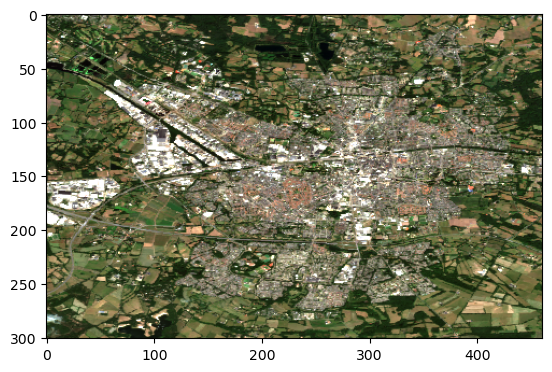

In [17]:
# This function normalizes each rgb band and helps you to have a better visualization.

def MyNormalize(img_i,sigma):
    nr,nc,nb = img_i.shape
    img_n = np.zeros(shape=(nr,nc,nb))
    for i in range(0,nb):
        one_band = img_i[:,:,i]
        mi = np.min(one_band)
        ma = np.max(one_band)
        one_band = (one_band-mi)/(ma-mi+np.finfo(float).eps)
        img_n[:,:,i] = sigma*one_band
    return img_n

plt.imshow(MyNormalize(img_rgb,5))

You can also export an image to Google Drive using the following line of code. This could be useful for example for big images. Moreover, you can download an image collection using geemap tools. See [this tutorial](https://geemap.org/notebooks/11_export_image/#exporting-all-bands-as-one-single-image) for more details.